# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-26 09:58:46.169284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

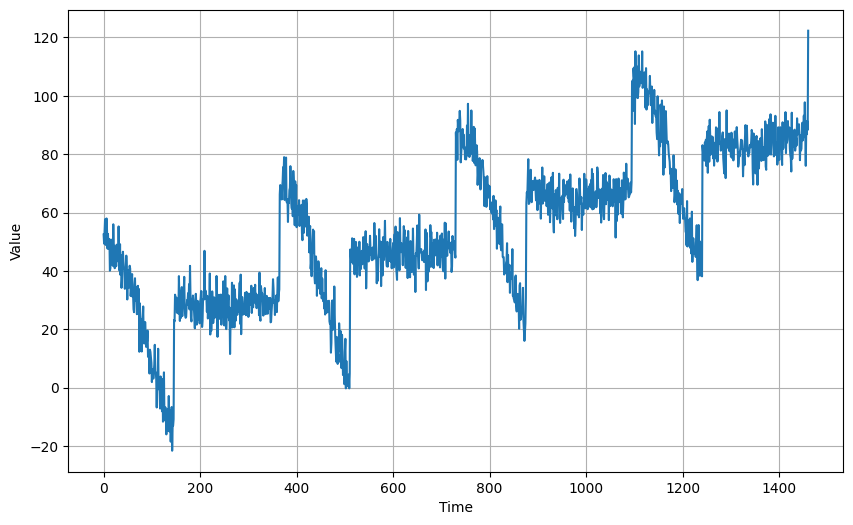

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-26 09:58:52.970300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
33/33 [==============================] - 3s 20ms/step - loss: 140.0870 - mae: 140.5870 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 132.2770 - mae: 132.7770 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 122.9639 - mae: 123.4639 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 112.5578 - mae: 113.0577 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 100.9837 - mae: 101.4828 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 10ms/step - loss: 88.1617 - mae: 88.6614 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 73.9893 - mae: 74.4890 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 58.4099 - mae: 58.9099 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 41.4263 - 

(1e-08, 0.0001, 0.0, 30.0)

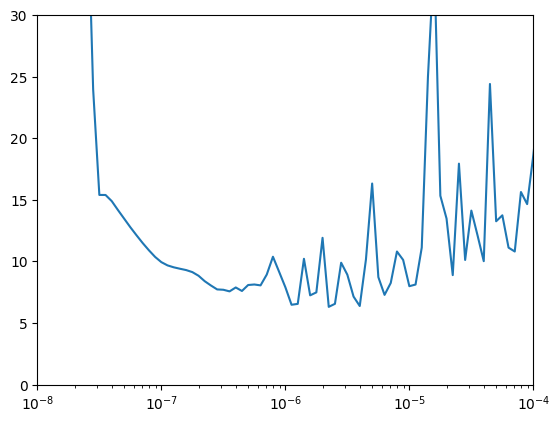

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

empirical_model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
empirical_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
empirical_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
empirical_model.fit(train_set, epochs = 20,
          validation_data=valid_set,
          callbacks=[early_stopping, empirical_model_checkpoint, reset_states])

Epoch 1/20
33/33 [==============================] - 4s 45ms/step - loss: 4073.0530 - mae: 4073.5520 - val_loss: 3775.4795 - val_mae: 3775.9797
Epoch 2/20
33/33 [==============================] - 1s 18ms/step - loss: 3148.6074 - mae: 3149.1077 - val_loss: 4862.7534 - val_mae: 4863.2539
Epoch 3/20
33/33 [==============================] - 1s 17ms/step - loss: 2474.3872 - mae: 2474.8875 - val_loss: 116.5364 - val_mae: 117.0364
Epoch 4/20
33/33 [==============================] - 1s 17ms/step - loss: 4549.2246 - mae: 4549.7246 - val_loss: 12020.9521 - val_mae: 12021.4512
Epoch 5/20
33/33 [==============================] - 1s 15ms/step - loss: 10795.3740 - mae: 10795.8730 - val_loss: 5876.0137 - val_mae: 5876.5137
Epoch 6/20
33/33 [==============================] - 0s 15ms/step - loss: 5339.9941 - mae: 5340.4941 - val_loss: 3052.6877 - val_mae: 3053.1875
Epoch 7/20
33/33 [==============================] - 0s 14ms/step - loss: 10195.8115 - mae: 10196.3135 - val_loss: 5605.2959 - val_mae: 5605.

In [10]:
empirical_model = keras.models.load_model("my_checkpoint.h5")

In [11]:
empirical_rnn_forecast = empirical_model.predict(series[np.newaxis, :, np.newaxis])
empirical_rnn_forecast = empirical_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 734ms/step


## Mechanized Forecasting with LSTM

In [12]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism


In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])




## Choose Mechanism and train the model

In [15]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

gaussian_history = mechanized_model.fit(train_set, epochs = 10,
                    callbacks=[lr_schedule, reset_states])



Epoch 1/10
In Gaussian Mechanism
Create noise when accessing the training data
      1/Unknown - 0s 255ms/step - loss: 47.1689 - mae: 47.6689In Gaussian Mechanism
Create noise when accessing the training data
      2/Unknown - 0s 155ms/step - loss: 39.6965 - mae: 40.1965In Gaussian Mechanism
Create noise when accessing the training data
      3/Unknown - 1s 163ms/step - loss: 34.1403 - mae: 34.6403In Gaussian Mechanism
Create noise when accessing the training data
      4/Unknown - 1s 164ms/step - loss: 29.5410 - mae: 30.0410In Gaussian Mechanism
Create noise when accessing the training data
      5/Unknown - 1s 162ms/step - loss: 30.8516 - mae: 31.3516In Gaussian Mechanism
Create noise when accessing the training data
      6/Unknown - 1s 160ms/step - loss: 32.2768 - mae: 32.7768In Gaussian Mechanism
Create noise when accessing the training data
      7/Unknown - 1s 160ms/step - loss: 31.5299 - mae: 32.0299In Gaussian Mechanism
Create noise when accessing the training data
      8/Unk

## Choose Threshold Mechanism And Fit The Model

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)


mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

threshold_history = mechanized_model.fit(train_set, epochs = 10,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/10
In Threshold out Mechanism
[17.138083]
      1/Unknown - 0s 328ms/step - loss: 9.3833 - mae: 4.6934In Threshold out Mechanism
[1.2568479]
      2/Unknown - 1s 318ms/step - loss: 7.1928 - mae: 5.2242In Threshold out Mechanism
[4.3752413]
      3/Unknown - 1s 283ms/step - loss: 6.5948 - mae: 5.3243In Threshold out Mechanism
[7.3132906]
      4/Unknown - 1s 273ms/step - loss: 8.8857 - mae: 8.5350In Threshold out Mechanism
[7.158052]
      5/Unknown - 1s 267ms/step - loss: 13.4964 - mae: 13.2464In Threshold out Mechanism
[16.020714]
      6/Unknown - 2s 262ms/step - loss: 12.4469 - mae: 11.7136In Threshold out Mechanism
[0.36557034]
      7/Unknown - 2s 256ms/step - loss: 11.2690 - mae: 10.7225In Threshold out Mechanism
[0.7872667]
      8/Unknown - 2s 252ms/step - loss: 10.4731 - mae: 10.0361In Threshold out Mechanism
[0.36658287]
      9/Unknown - 2s 248ms/step - loss: 9.6878 - mae: 9.5307  In Threshold out Mechanism
[0.9605082]
     10/Unknown - 3s 273ms/step - loss: 8.9603 -

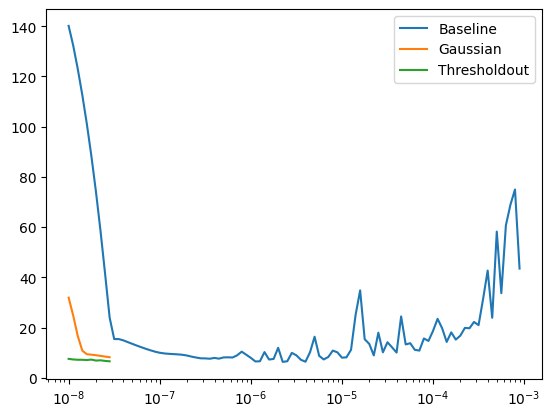

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()


## Create the Mechanized Model with Check in point

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])



## Choose the Gaussian Model and Train the model

In [19]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)



optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
reset_states = ResetStatesCallback()
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "mechanized_model_checkpoint.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
mechanized_model.fit(train_set, epochs = 10,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint, reset_states])

Epoch 1/10
In Gaussian Mechanism
Create noise when accessing the training data
      1/Unknown - 0s 263ms/step - loss: 34.2021 - mae: 34.7021In Gaussian Mechanism
Create noise when accessing the training data
      2/Unknown - 0s 225ms/step - loss: 1548.0282 - mae: 1548.5281In Gaussian Mechanism
Create noise when accessing the training data
      3/Unknown - 1s 190ms/step - loss: 3488.2629 - mae: 3488.7629In Gaussian Mechanism
Create noise when accessing the training data
      4/Unknown - 1s 177ms/step - loss: 2638.7319 - mae: 2639.2317In Gaussian Mechanism
Create noise when accessing the training data
      5/Unknown - 1s 171ms/step - loss: 3749.0591 - mae: 3749.5588In Gaussian Mechanism
Create noise when accessing the training data
      6/Unknown - 1s 175ms/step - loss: 3675.9832 - mae: 3676.4829In Gaussian Mechanism
Create noise when accessing the training data
      7/Unknown - 1s 174ms/step - loss: 3946.2312 - mae: 3946.7312In Gaussian Mechanism
Create noise when accessing the t

In [20]:
gaussian_model = keras.models.load_model("mechanized_model_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [21]:
gaussian_rnn_forecast = gaussian_model.predict(series[np.newaxis, :, np.newaxis])
gaussian_rnn_forecast = gaussian_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 780ms/step


## Choose the Thresholdout Model and Train the model

In [22]:
print(train_set)
mechanized_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
reset_states = ResetStatesCallback()
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "mechanized_model_checkpoint.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
mechanized_model.fit(train_set, epochs = 10,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint, reset_states])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>


Epoch 1/10
In Threshold out Mechanism
[5.952228]
      1/Unknown - 0s 275ms/step - loss: 26.5934 - mae: 27.7396In Threshold out Mechanism
[55.46298]
      2/Unknown - 1s 254ms/step - loss: 1659.9727 - mae: 1651.5520In Threshold out Mechanism
[36.81642]
      3/Unknown - 1s 246ms/step - loss: 4044.2166 - mae: 4042.7700In Threshold out Mechanism
[9.587772]
      4/Unknown - 1s 250ms/step - loss: 3375.7800 - mae: 3374.3931In Threshold out Mechanism
[1519.2554]
      5/Unknown - 1s 250ms/step - loss: 4215.5742 - mae: 4231.1411In Threshold out Mechanism
[308.26526]
      6/Unknown - 2s 288ms/step - loss: 3672.3311 - mae: 3687.2781In Threshold out Mechanism
[1956.0052]
      7/Unknown - 2s 293ms/step - loss: 5292.1494 - mae: 5302.8428In Threshold out Mechanism
[110.34964]
      8/Unknown - 2s 285ms/step - loss: 6511.3550 - mae: 6523.2466In Threshold out Mechanism
[29.475985]
      9/Unknown - 3s 279ms/step - loss: 6181.0269 - mae: 6191.4038In Threshold out Mechanism
[0.9846354]
     10/Unkno

In [23]:
threshold_model = keras.models.load_model("mechanized_model_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [24]:
threshold_rnn_forecast = threshold_model.predict(series[np.newaxis, :, np.newaxis])
threshold_rnn_forecast = threshold_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 778ms/step


## Plot the comparison results

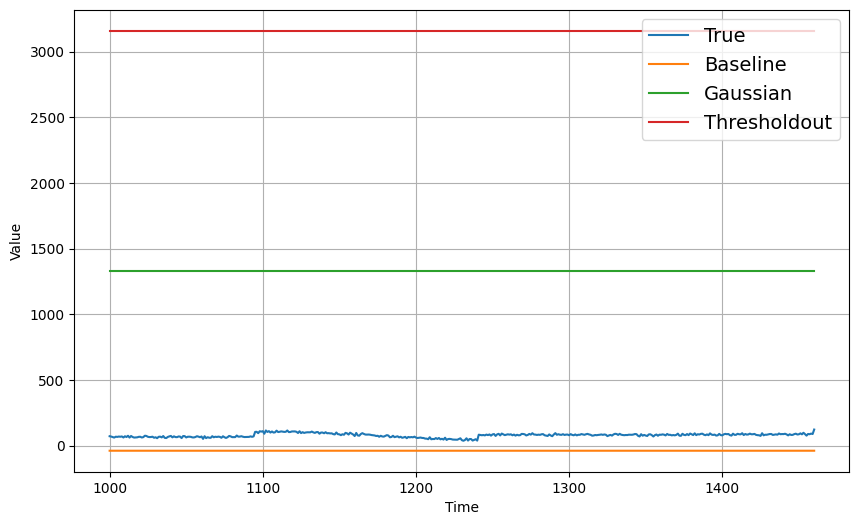

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, empirical_rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")
plot_series(time_valid, threshold_rnn_forecast, label = "Thresholdout")


In [26]:
keras.metrics.mean_absolute_error(x_valid, empirical_rnn_forecast).numpy()

117.31789

In [28]:
keras.metrics.mean_absolute_error(x_valid, threshold_rnn_forecast).numpy()

3080.0752

In [27]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

1252.5366